# Deep Learning (DL) Applications in Single-Cell Analysis

## Learning Objectives

After this lecture, you will be able to:
Understand why deep learning is needed in single-cell analysis
- Explain key DL applications in scRNA-seq
- Interpret scVI / scANVI outputs biologically
Connect code outputs to biological questions


## Why Single-Cell Data Is Hard
- Extremely high dimensional (20,000+ genes)
- Sparse data (dropouts)
- Noisy measurements
- Nonlinear biological relationships
- Strong batch effects

## Why Deep Learning?
**Classical Methods (Limitations)**
- PCA → linear
- k-means → sensitive to noise
- Manual annotation → subjective

**Deep Learning Advantages**
- Learns nonlinear patterns
- Handles noise and sparsity
- Scales to large datasets
- Learns latent biological structure

## Overview of DL Applications in Single-Cell Analysis
- Representation learning
- Cell clustering & state discovery
- Batch effect correction
- Denoising / imputation
- Cell type annotation
- Trajectory inference

## Install & imports

In [1]:
# If needed (Colab / fresh env)
%%capture
!pip -q install scanpy scvi-tools anndata leidenalg igraph

In [2]:
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import scanpy as sc
import anndata as ad
import numpy as np

# Deep learning (single-cell)
import scvi

sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi=120)

## Load Scanpy built-in dataset (PBMC3k)

In [4]:
# built-in dataset
adata = sc.datasets.pbmc3k()
adata

try downloading from url
https://falexwolf.de/data/pbmc3k_raw.h5ad
... this may take a while but only happens once


  0%|          | 0.00/5.58M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [5]:
adata.obs

""
index
AAACATACAACCAC-1
AAACATTGAGCTAC-1
AAACATTGATCAGC-1
AAACCGTGCTTCCG-1
AAACCGTGTATGCG-1
...
TTTCGAACTCTCAT-1
TTTCTACTGAGGCA-1
TTTCTACTTCCTCG-1


## Basic QC + filtering (typical single-cell preprocessing)

In [6]:
# annotate mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

# filter cells & genes (simple defaults)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# filter high MT% cells (optional)
adata = adata[adata.obs.pct_counts_mt < 15].copy()

adata

filtered out 19024 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 2698 × 13714
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [7]:
import numpy as np
import scanpy as sc
import scipy
import matplotlib.pyplot as plt


def calculate_qc_metrics(
    adata,
    mt_prefix="MT-",
    rb_prefix="RPS|RPL",
    hb_genes=["HBA1", "HBA@", "HBB"],
    min_genes=200,
    max_genes=2500,
    max_mt_percent=5,
):
    """
    Calculate and visualize comprehensive single-cell QC metrics.

    Gene naming conventions:
    -------------------------
    Mitochondrial genes:
        - Mouse: 'mt-'
        - Human: 'MT-'

    Ribosomal genes:
        - Mouse: 'Rps', 'Rpl'
        - Human: 'RPS', 'RPL'

    Hemoglobin genes:
        - Mouse: Hba-a1, Hba-a2, Hbb-bs
        - Human: HBA1, HBA2, HBB

    Parameters
    ----------
    adata : AnnData
        Annotated data matrix
    mt_prefix : str
        Prefix for mitochondrial genes
    rb_prefix : str
        Regex pattern for ribosomal genes
    hb_genes : list
        List of hemoglobin genes
    min_genes : int
        Minimum genes per cell (visual guide)
    max_genes : int
        Maximum genes per cell (visual guide)
    max_mt_percent : float
        Maximum mitochondrial percentage (visual guide)
    """

    # Identify gene categories
    adata.var["mt"] = adata.var_names.str.startswith(mt_prefix)
    adata.var["ribo"] = adata.var_names.str.contains(f"^({rb_prefix})")
    adata.var["hb"] = adata.var_names.isin(hb_genes)

    # Compute QC metrics
    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars=["mt", "ribo", "hb"],
        percent_top=None,
        log1p=False,
        inplace=True,
    )

    # Additional metrics
    if scipy.sparse.issparse(adata.X):
        adata.obs["n_genes"] = (adata.X > 0).sum(axis=1).A1
    else:
        adata.obs["n_genes"] = (adata.X > 0).sum(axis=1)

    adata.obs["log10_total_counts"] = np.log10(adata.obs["total_counts"] + 1)

    # QC violin plots (Scanpy-managed)
    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"],
        jitter=0.4,
        multi_panel=True,
        show=True,
    )

    # Custom diagnostic plots
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))

    # Counts vs genes
    axes[0].scatter(
        adata.obs["total_counts"],
        adata.obs["n_genes_by_counts"],
        c=adata.obs["pct_counts_mt"],
        s=2,
        alpha=0.5,
    )
    axes[0].set_xlabel("Total counts")
    axes[0].set_ylabel("Genes per cell")

    # Gene count distribution
    axes[1].hist(adata.obs["n_genes_by_counts"], bins=50, alpha=0.7)
    axes[1].axvline(min_genes, color="red", linestyle="--")
    axes[1].axvline(max_genes, color="red", linestyle="--")
    axes[1].set_xlabel("Genes per cell")

    # Mitochondrial percentage
    axes[2].hist(adata.obs["pct_counts_mt"], bins=50, alpha=0.7)
    axes[2].axvline(max_mt_percent, color="red", linestyle="--")
    axes[2].set_xlabel("Mitochondrial %")

    # Library complexity
    axes[3].scatter(
        adata.obs["log10_total_counts"],
        adata.obs["n_genes_by_counts"] / adata.obs["total_counts"],
        s=2,
        alpha=0.5,
    )
    axes[3].set_xlabel("log10(total counts)")
    axes[3].set_ylabel("Genes per UMI")

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\nQC summary:")
    print(f"Cells: {adata.n_obs}")
    print(f"Median genes per cell: {adata.obs['n_genes_by_counts'].median():.0f}")
    print(f"Median counts per cell: {adata.obs['total_counts'].median():.0f}")
    print(f"Median MT%: {adata.obs['pct_counts_mt'].median():.2f}")

    return adata

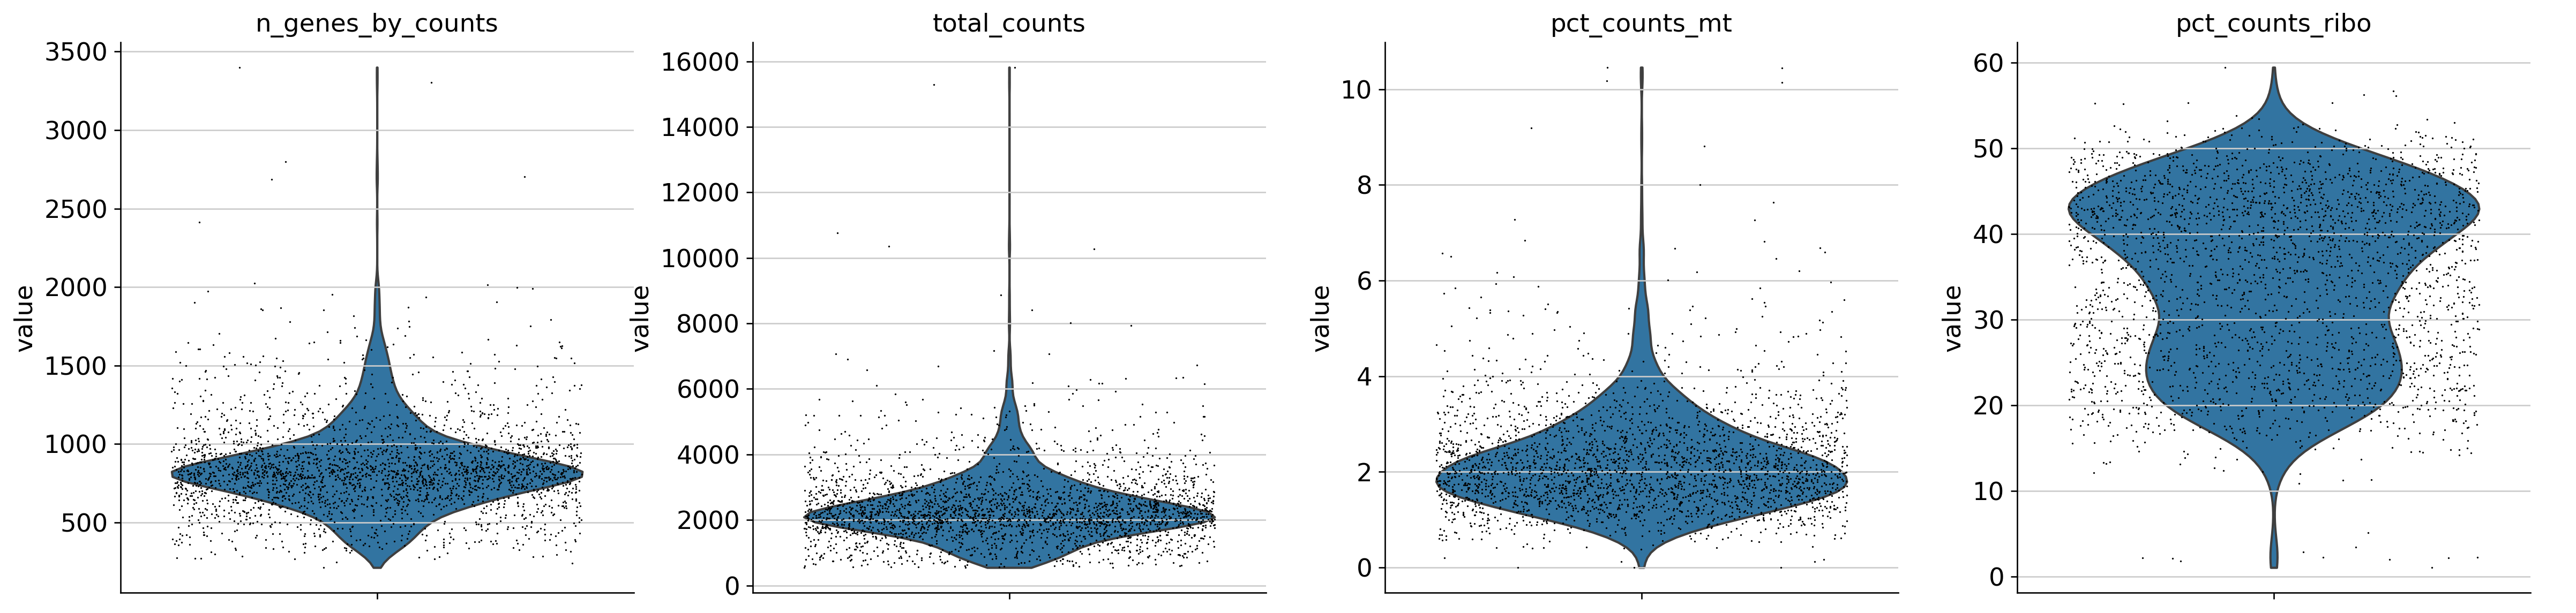

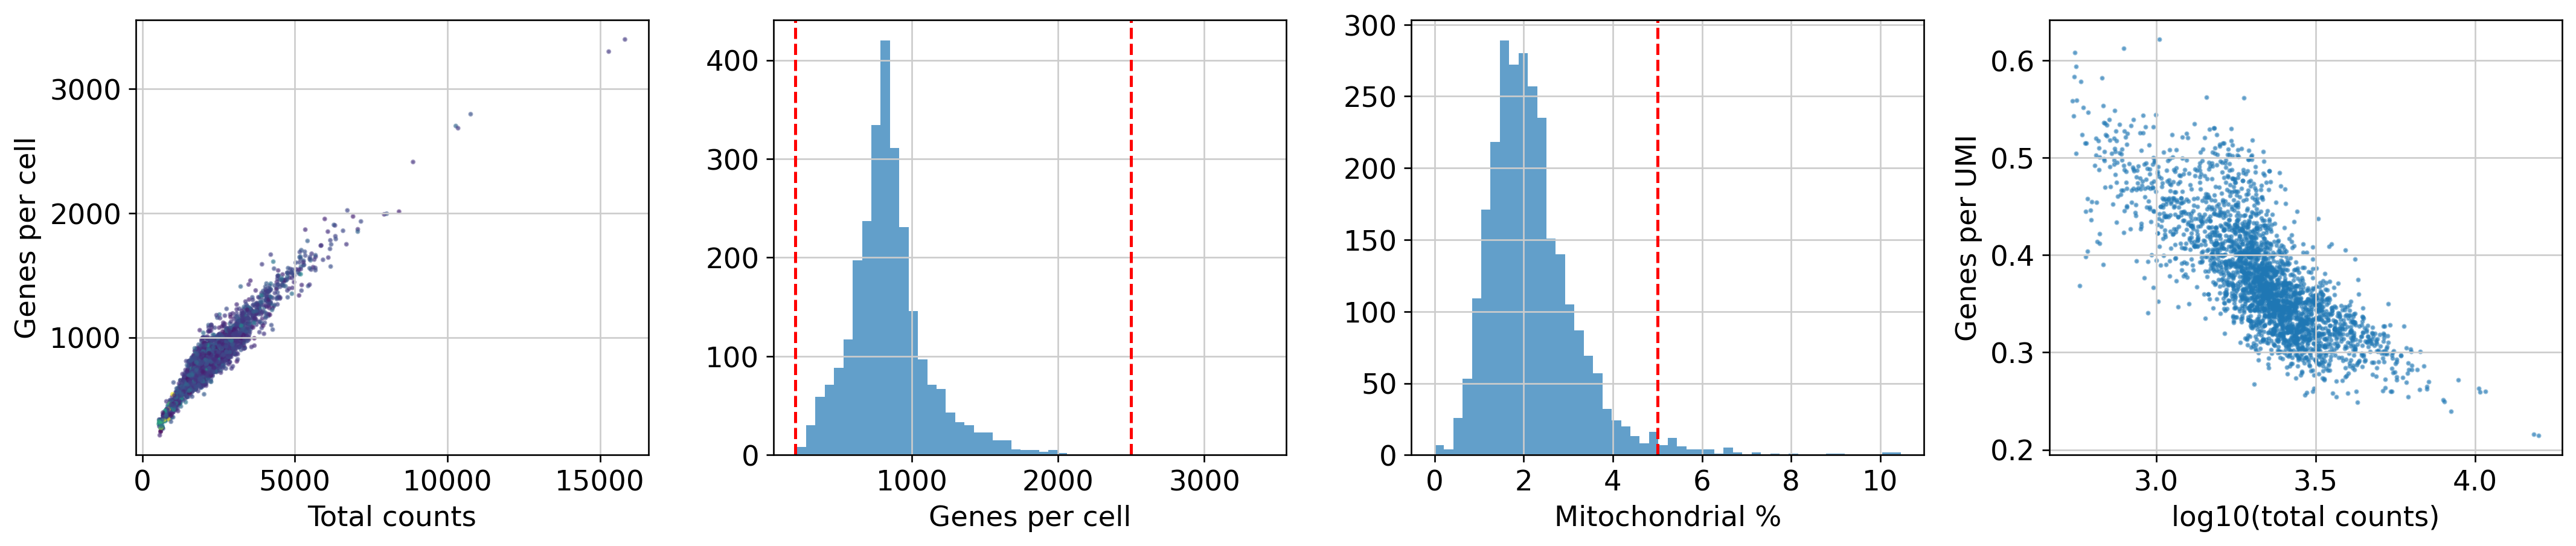


QC summary:
Cells: 2698
Median genes per cell: 816
Median counts per cell: 2196
Median MT%: 2.03


In [9]:
adata = calculate_qc_metrics(adata)

In [11]:
adata

AnnData object with n_obs × n_vars = 2698 × 13714
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'log10_total_counts'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'ribo', 'hb'

In [10]:
adata.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb,log10_total_counts
index,,,,,,,,,,
AAACATACAACCAC-1,779,2419.0,73.0,3.017776,779,1057.0,43.695744,0.0,0.0,3.383816
AAACATTGAGCTAC-1,1352,4903.0,186.0,3.793596,1352,2079.0,42.402611,0.0,0.0,3.690551
AAACATTGATCAGC-1,1129,3147.0,28.0,0.889736,1129,997.0,31.680965,0.0,0.0,3.498035
AAACCGTGCTTCCG-1,960,2639.0,46.0,1.743085,960,640.0,24.251610,0.0,0.0,3.421604
AAACCGTGTATGCG-1,521,980.0,12.0,1.224490,521,146.0,14.897959,0.0,0.0,2.991669
...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,1153,3459.0,73.0,2.110436,1153,939.0,27.146574,0.0,0.0,3.539076
TTTCTACTGAGGCA-1,1224,3443.0,32.0,0.929422,1224,1142.0,33.168747,0.0,0.0,3.537063
TTTCTACTTCCTCG-1,622,1684.0,37.0,2.197150,622,670.0,39.786224,0.0,0.0,3.226600


## Normalize + log-transform + HVGs

In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# store raw for later use (marker genes etc.)
adata.raw = adata

# highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat_v3")
adata = adata[:, adata.var.highly_variable].copy()

adata

normalizing counts per cell
    finished (0:00:02)
extracting highly variable genes


AnnData object with n_obs × n_vars = 2698 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'log10_total_counts'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'ribo', 'hb', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'

In [13]:
adata.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb,log10_total_counts
index,,,,,,,,,,
AAACATACAACCAC-1,779,2419.0,73.0,3.017776,779,1057.0,43.695744,0.0,0.0,3.383816
AAACATTGAGCTAC-1,1352,4903.0,186.0,3.793596,1352,2079.0,42.402611,0.0,0.0,3.690551
AAACATTGATCAGC-1,1129,3147.0,28.0,0.889736,1129,997.0,31.680965,0.0,0.0,3.498035
AAACCGTGCTTCCG-1,960,2639.0,46.0,1.743085,960,640.0,24.251610,0.0,0.0,3.421604
AAACCGTGTATGCG-1,521,980.0,12.0,1.224490,521,146.0,14.897959,0.0,0.0,2.991669
...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,1153,3459.0,73.0,2.110436,1153,939.0,27.146574,0.0,0.0,3.539076
TTTCTACTGAGGCA-1,1224,3443.0,32.0,0.929422,1224,1142.0,33.168747,0.0,0.0,3.537063
TTTCTACTTCCTCG-1,622,1684.0,37.0,2.197150,622,670.0,39.786224,0.0,0.0,3.226600


## Classical baseline: PCA → neighbors → UMAP → Leiden

computing PCA
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:26)
computing UMAP
    finished (0:00:04)
running Leiden clustering
    finished (0:00:01)


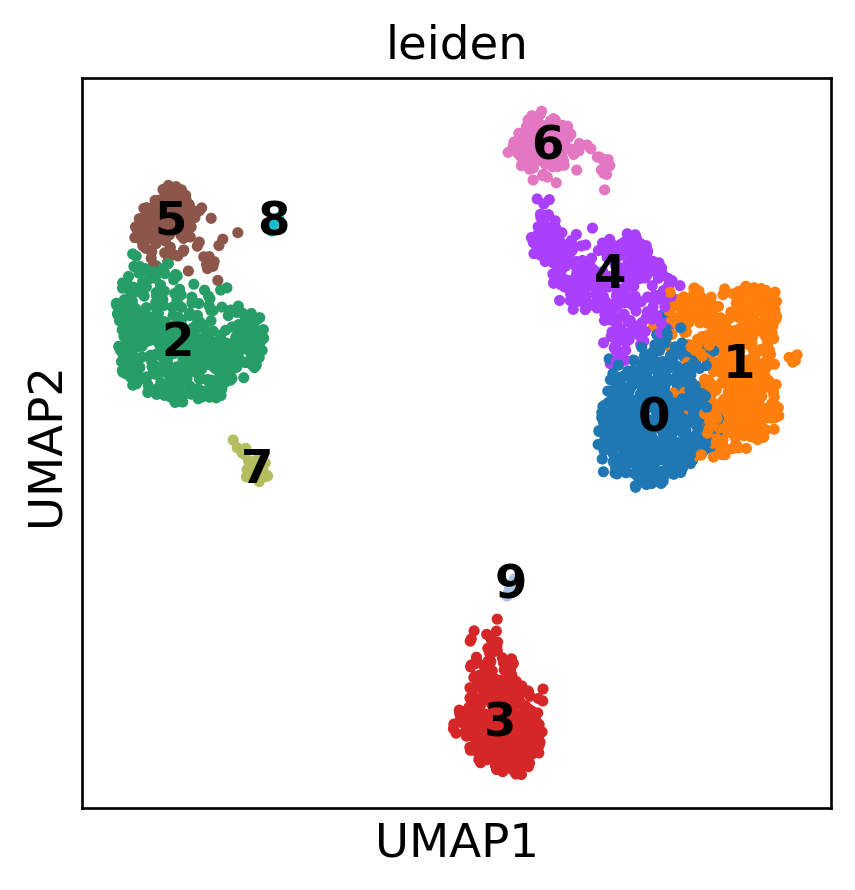

In [14]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.7)

sc.pl.umap(adata, color=["leiden"], legend_loc="on data")

### What this figure fundamentally represents
- Each dot = one cell
- UMAP1 / UMAP2 = low-dimensional embeddings of high-dimensional gene expression profiles
- Colors / numbers (0–9) = Leiden clusters, i.e., graph-based communities of transcriptionally similar cells
- Distance on UMAP ≈ similarity (local, not global)

**Important caveat:** UMAP is non-linear. Absolute distances and axes do not have biological units.

How to read cluster separation vs proximity
- Cluster 3 (red, bottom-right), Cluster 7 (olive, isolated), and Cluster 6 (pink, top) - Likely distinct cell types, rare populations, or strong activation states
- Often characterized by unique marker genes


- Clusters 0, 1, 4 (right-side vertical structure), and Clusters 2, 5, 8 (left-side group)

May represent:
- Differentiation trajectories
- Activation gradients
- Cell-cycle effects
- Subtypes within one lineage

These should often be interpreted together, not independently.

**Interpreting each region of your UMAP**
- Right-side major lineage (clusters 0, 1, 4, 6)
- Cluster 0 and Cluster 1: Strong overlap → highly similar transcriptomes
- Possibly:
    - Same cell type, different activation states
    - Cycling vs non-cycling
    - Technical split at higher Leiden resolution

- Cluster 4
    - Bridges 0/1 and 6
    - Suggests intermediate or transitional state

- Cluster 6
- More distant but still connected
- Likely:
    - Differentiated endpoint
    - Activated or stressed subpopulation

📌 Hypothesis: a continuous lineage with gradual transcriptional change.

Left-side lineage (clusters 2, 5, 8)
- 2: large, dense → dominant population
- 5: adjacent but more compact → subtype or activation state
- 8: small, peripheral → rare or transient cells

📌 Interpretation: same lineage, possibly resting → activated progression.

## Deep learning applications

## DL Application #1: Representation learning + denoising (scVI)

**Problem in single-cell data**
- scRNA-seq data are high-dimensional (~20,000 genes)
- Highly sparse (dropouts)
- Non-linear gene–gene relationships
- PCA captures only linear structure

**What deep learning does**
- scVI uses a [Variational Autoencoder (VAE)](https://www.geeksforgeeks.org/machine-learning/variational-autoencoders/)
- Learns a low-dimensional latent space that:
    - Preserves biological variation
    - Suppresses technical noise
    - Models count distributions explicitly

**When to use**
- Always recommended for medium–large scRNA-seq datasets
- Especially useful before clustering or trajectory analysis



filtered out 19024 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/200 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


computing neighbors
    finished (0:00:00)
computing UMAP
    finished (0:00:03)
running Leiden clustering
    finished (0:00:00)


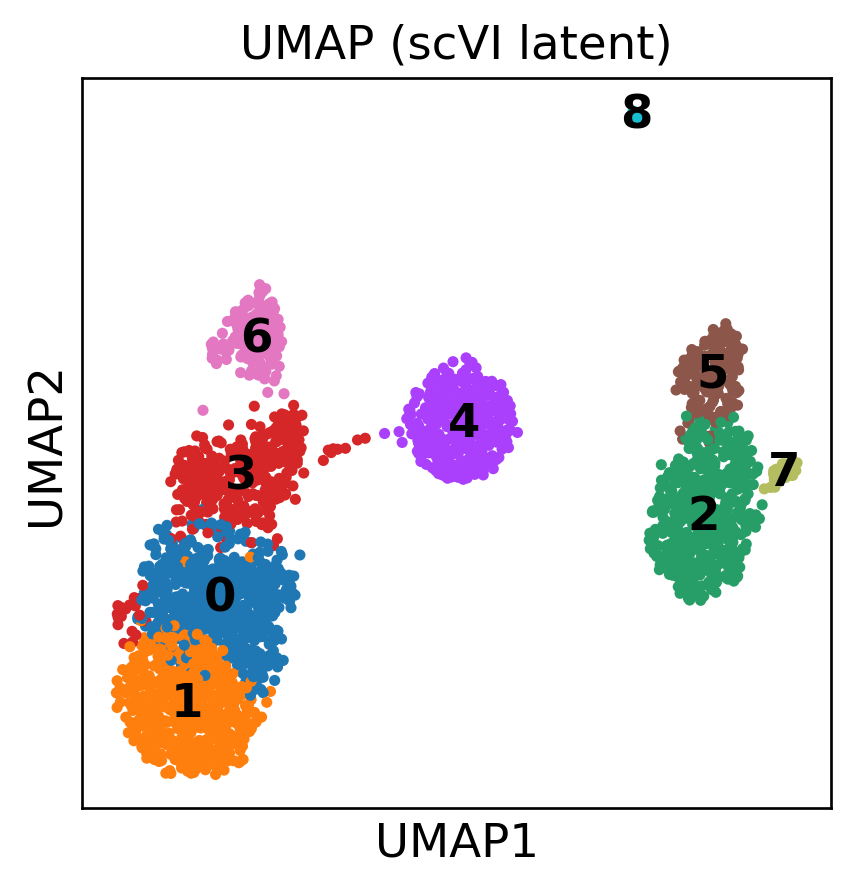

In [15]:
adata = sc.datasets.pbmc3k()  # .X is raw-ish counts

# QC / filtering
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs.pct_counts_mt < 15].copy()

# IMPORTANT: store raw counts BEFORE normalization/log
adata.layers["counts"] = adata.X.copy()

# HVG pipeline can use normalized/logged X (layer stays raw counts)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # optional (stores log-normalized snapshot)

sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat_v3")
adata = adata[:, adata.var.highly_variable].copy()
# (layers are automatically subset when you subset adata)

# scVI on raw counts layer
scvi.model.SCVI.setup_anndata(adata, layer="counts")
model = scvi.model.SCVI(adata, n_latent=10)
model.train(max_epochs=200)

adata.obsm["X_scVI"] = model.get_latent_representation()

sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.7)

sc.pl.umap(adata, color=["leiden"], legend_loc="on data", title="UMAP (scVI latent)")

**Leiden (PCA) asks:** Which cells are similar after standard preprocessing?

**scVI latent asks:** Which cells are similar after explicitly modeling noise, batch effects, and count distributions?

**In the scVI UMAP:**

Clusters (e.g., 0, 2, 3, 4) are tighter

Boundaries are clearer

Less “stringy” or elongated structures

**Interpretation**
scVI compresses technical noise and stabilizes within-cluster variance.

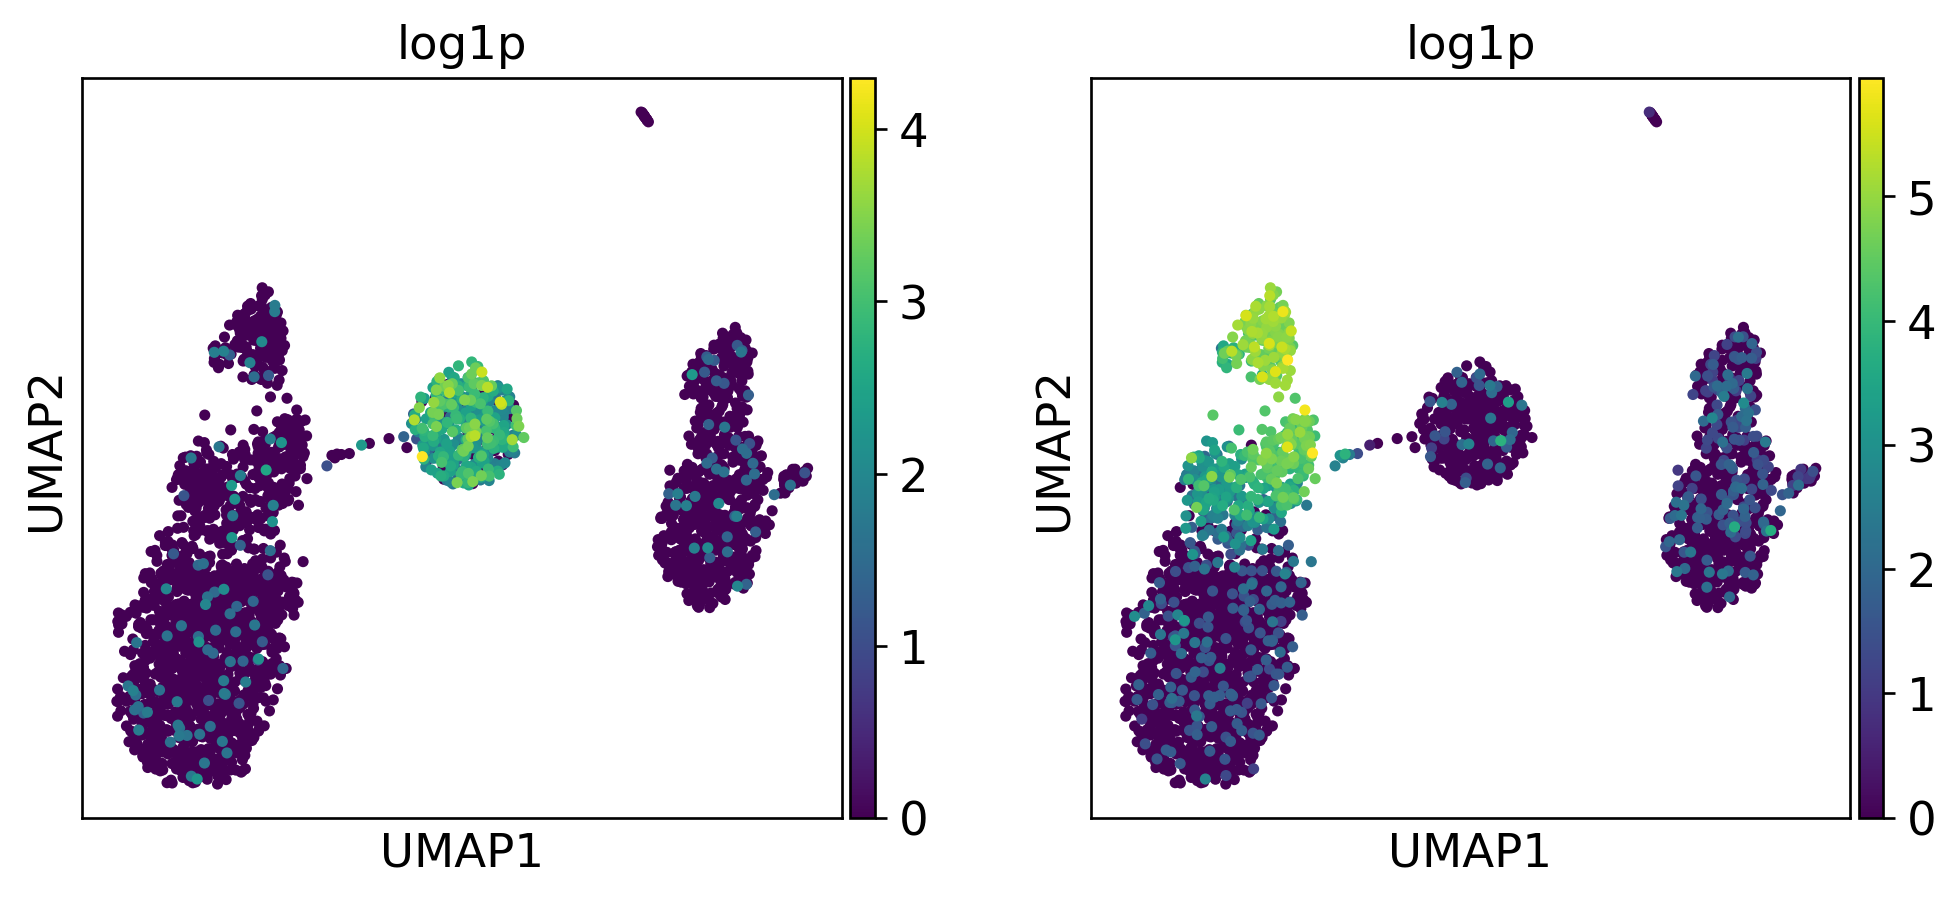

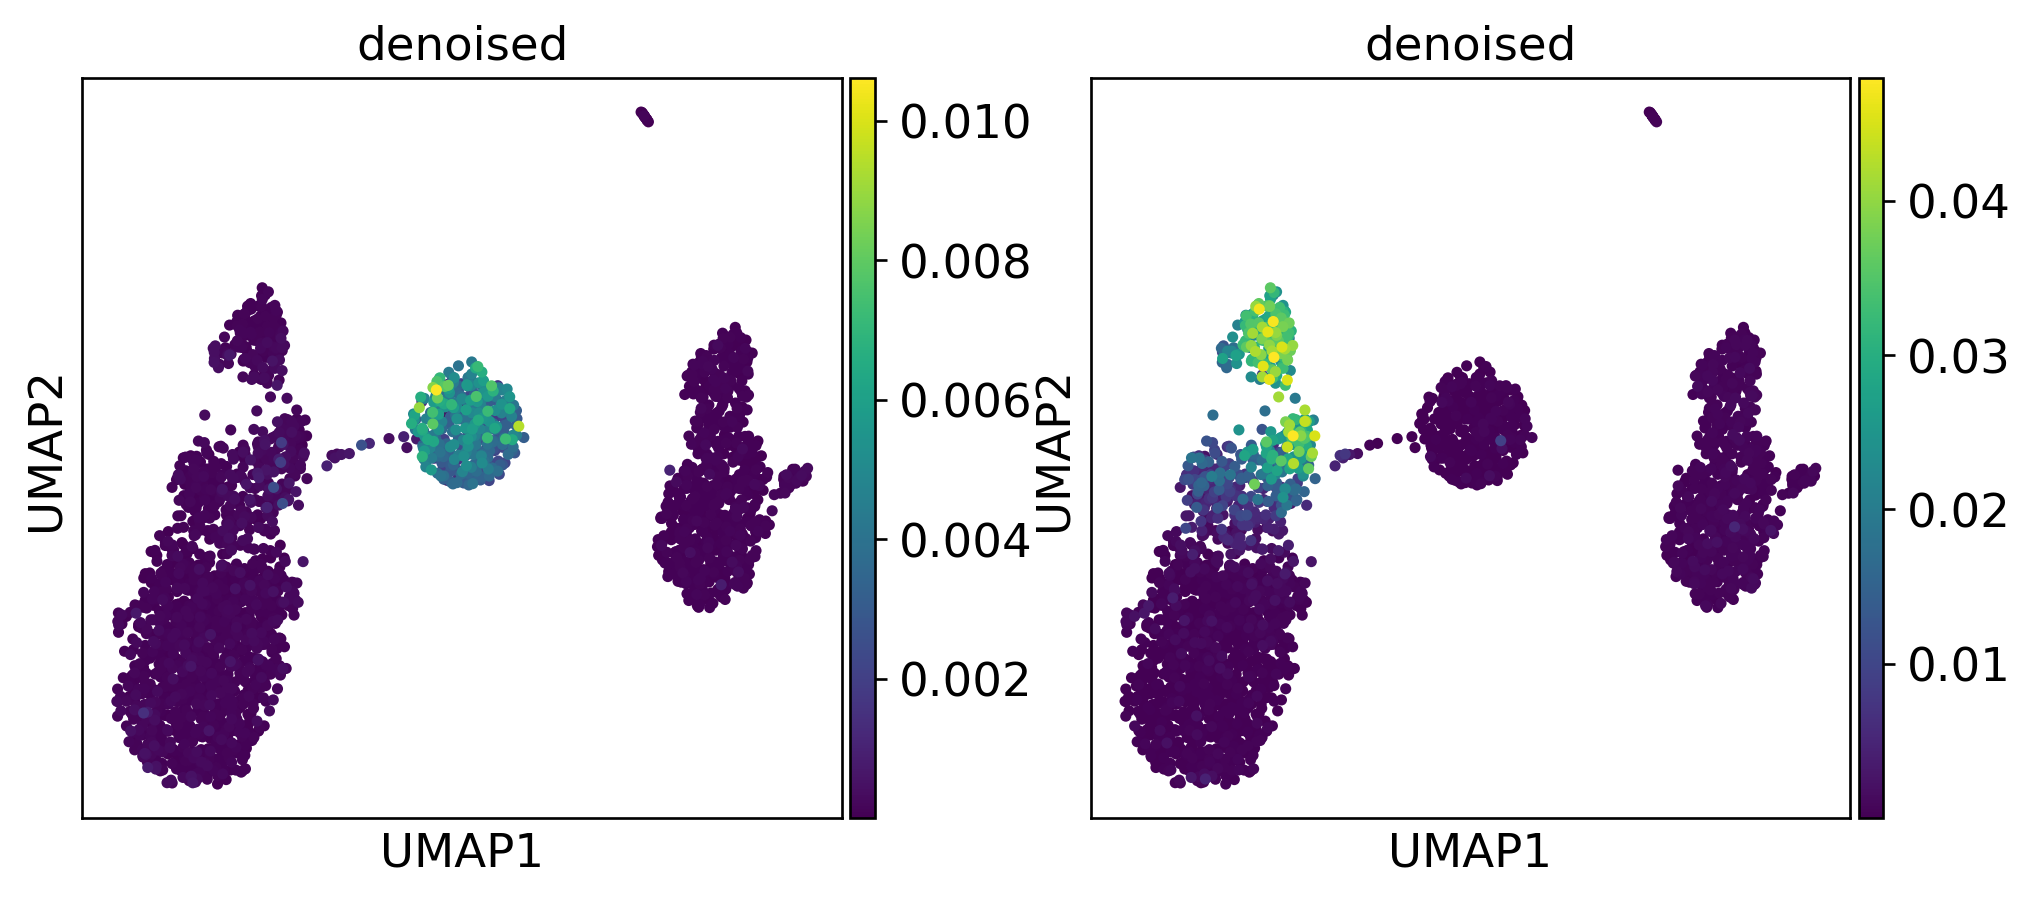

In [16]:
# Optional: denoised expression (DL denoising / imputation-like)
# Denoised normalized expression (use cautiously)
denoised = model.get_normalized_expression(return_numpy=True)

# put a small subset into a layer for downstream plotting if you want
# (storing full matrix is ok for pbmc3k size)
adata.layers["denoised"] = denoised.astype(np.float32)

# compare a marker in raw log1p vs denoised
sc.pl.umap(adata, color=["MS4A1", "NKG7"], layer=None, title=["log1p", "log1p"])
sc.pl.umap(adata, color=["MS4A1", "NKG7"], layer="denoised", title=["denoised", "denoised"])

This figure shows that **log1p-normalized** gene expression is low and diffuse across most clusters in the PCA-based embedding, but becomes spatially coherent and lineage-restricted in the scVI latent embedding, indicating improved denoising and biological signal recovery.

## DL Application #2: Batch correction / integration (scVI with batch)

**Problem**
- Technical variation from:
    - Different labs
    - Sequencing platforms
    - Sample preparation
- Batch effects can dominate biology

**How DL solves this**
- scVI explicitly models batch as a covariate
- Learns a batch-invariant latent space
- Removes nonlinear batch effects

**When to use**
- Multi-sample studies
- Meta-analysis
- Cross-platform integration

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/200 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


computing neighbors
    finished (0:00:00)
computing UMAP
    finished (0:00:04)
running Leiden clustering
    finished (0:00:00)


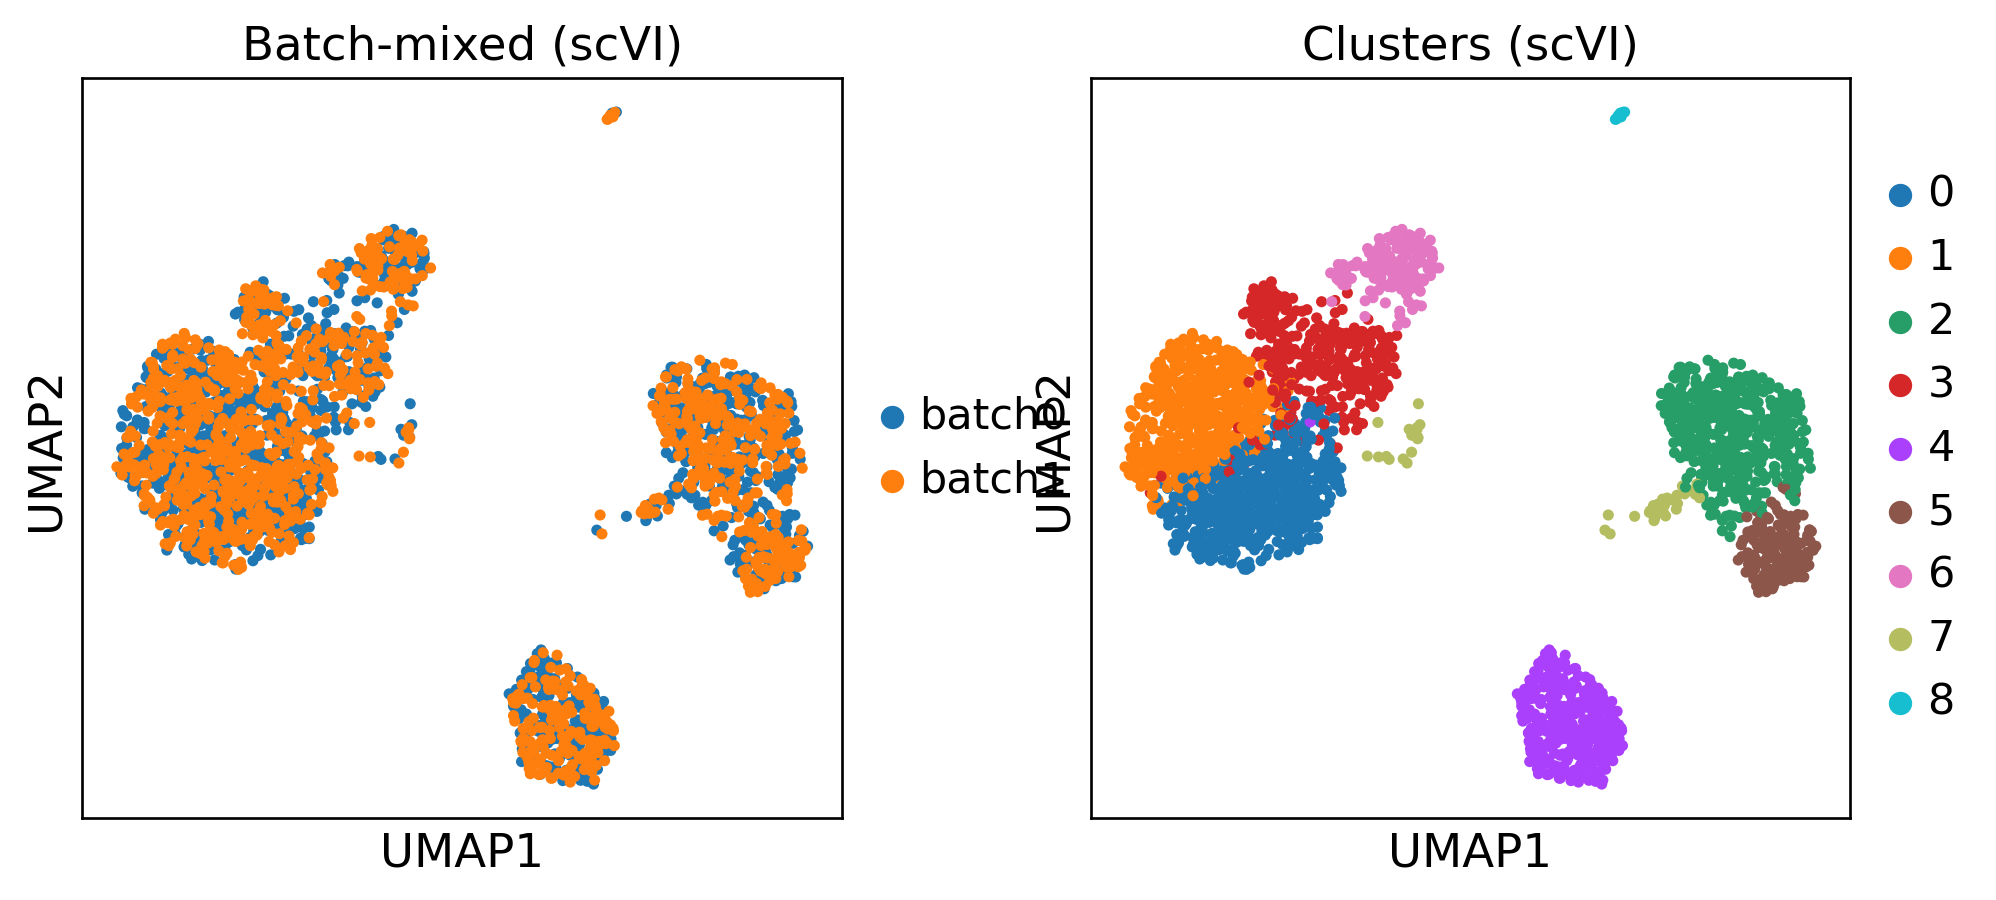

In [17]:
adata_b = adata.copy()

# create a fake batch label for demonstration
adata_b.obs["batch"] = "batch1"
adata_b.obs.loc[adata_b.obs_names[: adata_b.n_obs // 2], "batch"] = "batch0"

scvi.model.SCVI.setup_anndata(adata_b, layer="counts", batch_key="batch")
m_b = scvi.model.SCVI(adata_b, n_latent=10)
m_b.train(max_epochs=200)

adata_b.obsm["X_scVI_batch"] = m_b.get_latent_representation()

sc.pp.neighbors(adata_b, use_rep="X_scVI_batch")
sc.tl.umap(adata_b)
sc.tl.leiden(adata_b, resolution=0.7)

sc.pl.umap(adata_b, color=["batch", "leiden"], title=["Batch-mixed (scVI)", "Clusters (scVI)"])

In short: The analysis successfully removed technical "noise" (batch effects) while preserving the biological identity of the cells.

## DL Application #3: Cell type annotation (semi-supervised) with scANVI

**Problem**

Manual annotation:
- Time-consuming
- Subjective
- Not scalable

**DL solution**

- scANVI extends scVI
Combines:
    - Labeled cells
    - Unlabeled cells
- Propagates labels using latent structure

normalizing counts per cell
    finished (0:00:00)
computing score 'score_B_cell'
    finished (0:00:00)
computing score 'score_T_cell'
    finished (0:00:00)
computing score 'score_NK_cell'
    finished (0:00:00)
computing score 'score_Mono'
    finished (0:00:00)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/200 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


INFO     Training for 200 epochs.                                                                                  


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/200 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


computing neighbors
    finished (0:00:00)
computing UMAP
    finished (0:00:04)


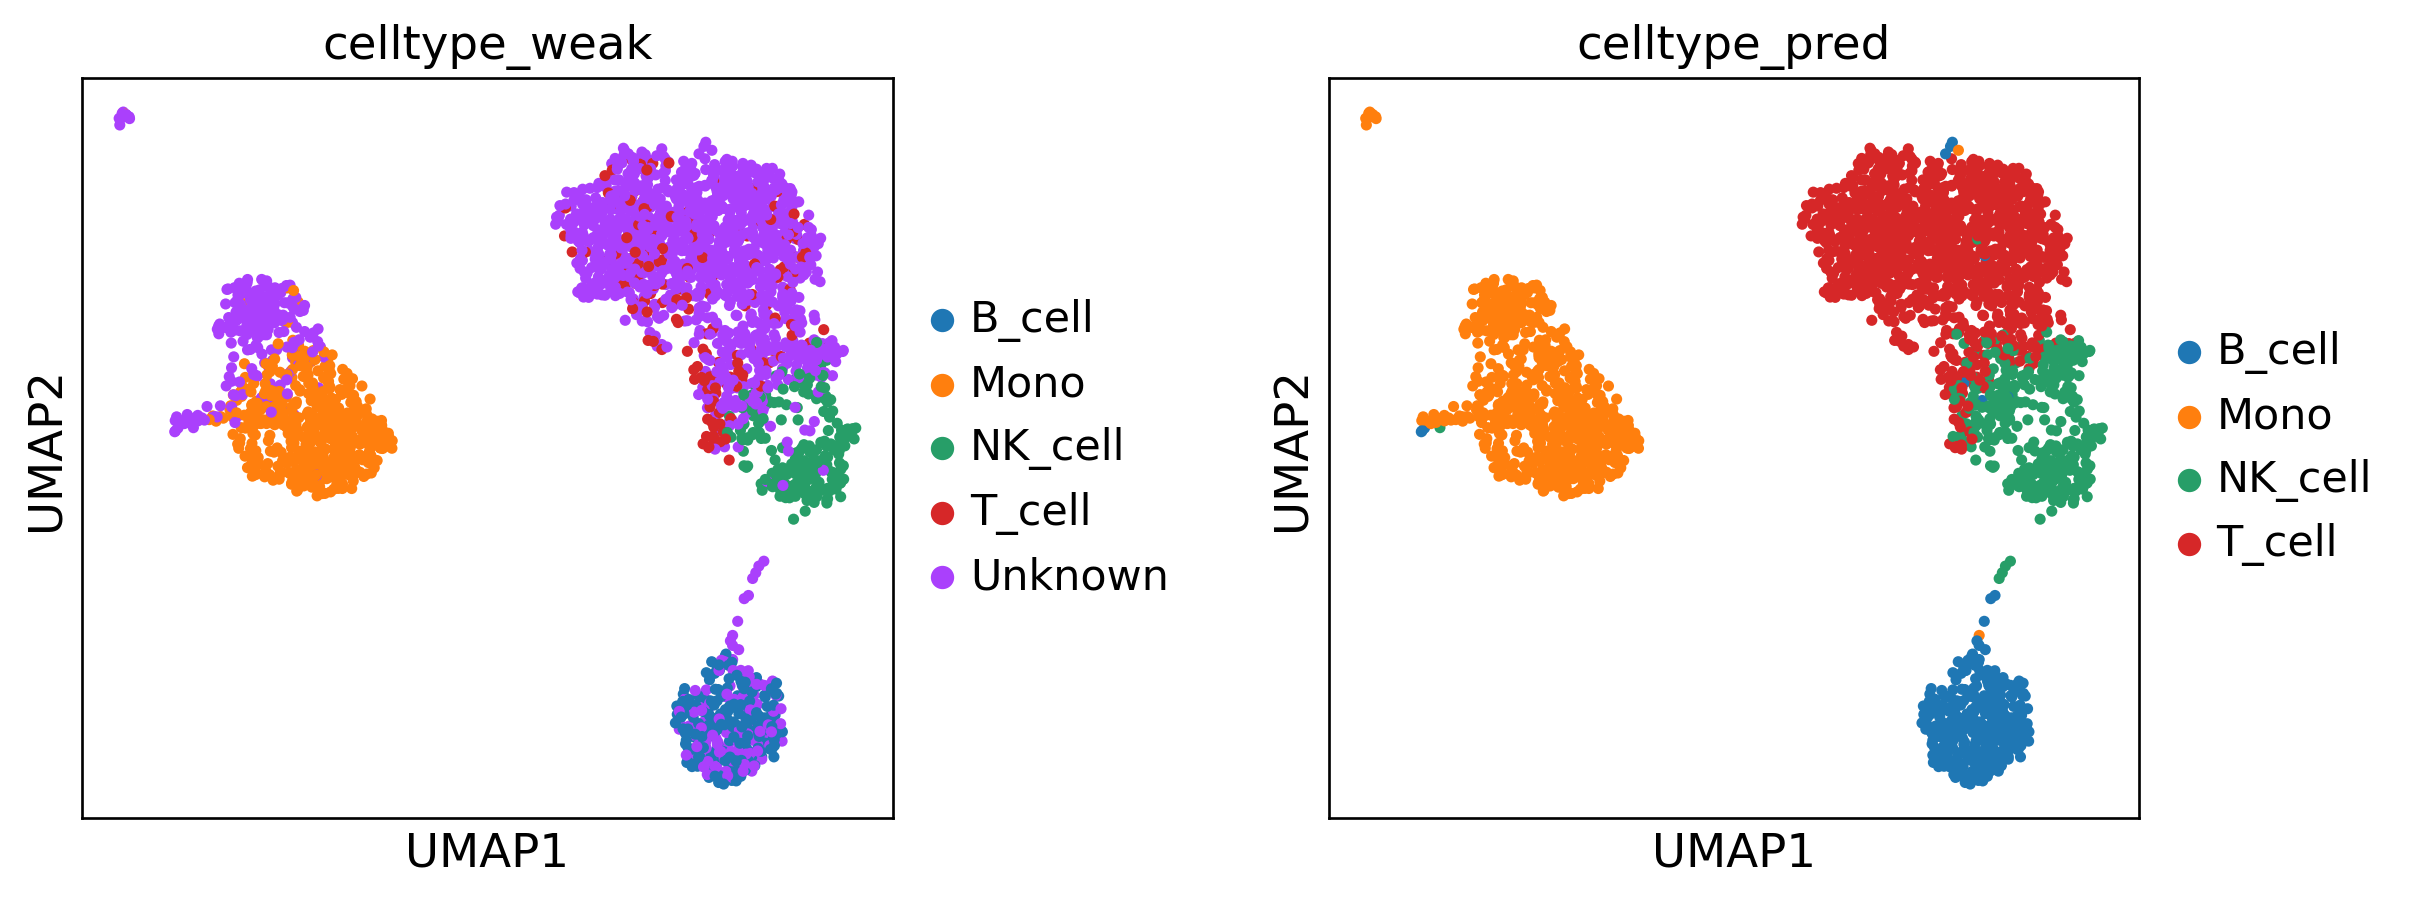

In [18]:
adata_lab = adata.copy()

# quick heuristic labels from marker expression (very simple demo!)
# Use raw log1p data in .raw for markers if available; otherwise use current
sc.pp.normalize_total(adata_lab, target_sum=1e4)
sc.pp.log1p(adata_lab)

# marker-based score
markers = {
    "B_cell": ["MS4A1", "CD79A"],
    "T_cell": ["CD3D", "TRAC"],
    "NK_cell": ["NKG7", "GNLY"],
    "Mono":   ["LYZ", "S100A8"],
}

for k, genes in markers.items():
    genes = [g for g in genes if g in adata_lab.var_names]
    sc.tl.score_genes(adata_lab, gene_list=genes, score_name=f"score_{k}")

scores = np.vstack([adata_lab.obs[f"score_{k}"].values for k in markers.keys()]).T
best = scores.argmax(1)
best_score = scores.max(1)

label_names = list(markers.keys())
labels = np.array([label_names[i] for i in best], dtype=object)

# only keep "confident" labels, others become Unknown
labels[best_score < np.percentile(best_score, 60)] = "Unknown"
adata_lab.obs["celltype_weak"] = labels

# Train scVI first, then scANVI
scvi.model.SCVI.setup_anndata(adata_lab, layer="counts")
m = scvi.model.SCVI(adata_lab, n_latent=10)
m.train(max_epochs=200)

scanvi = scvi.model.SCANVI.from_scvi_model(
    m,
    labels_key="celltype_weak",
    unlabeled_category="Unknown"
)
scanvi.train(max_epochs=200)

# predicted labels
adata_lab.obs["celltype_pred"] = scanvi.predict()

# visualize
adata_lab.obsm["X_scanvi"] = scanvi.get_latent_representation()
sc.pp.neighbors(adata_lab, use_rep="X_scanvi")
sc.tl.umap(adata_lab)

sc.pl.umap(adata_lab, color=["celltype_weak", "celltype_pred"], wspace=0.4)

This figure illustrates a label projection or cell-type annotation task in single-cell RNA sequencing (scRNA-seq). It compares low-quality "weak" initial labels with "predicted" labels generated by a deep learning model.

## DL Application #4: Trajectory / pseudotime on DL latent (common combo)

**Problem**
- Cell differentiation is:
    - Continuous
    - Nonlinear
- Trajectory inference depends heavily on representation quality

**DL advantage**
scVI latent:
    - Smooth
    - Noise-reduced
    - Biologically meaningful

computing neighbors
    finished (0:00:00)
computing UMAP
    finished (0:00:04)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9978943  0.99365115 0.99239486 0.97731453 0.957916
     0.9351773  0.93107283 0.90362316 0.88519174 0.8727452  0.8689232
     0.86375034 0.86329937 0.85797745]
    finished (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00)


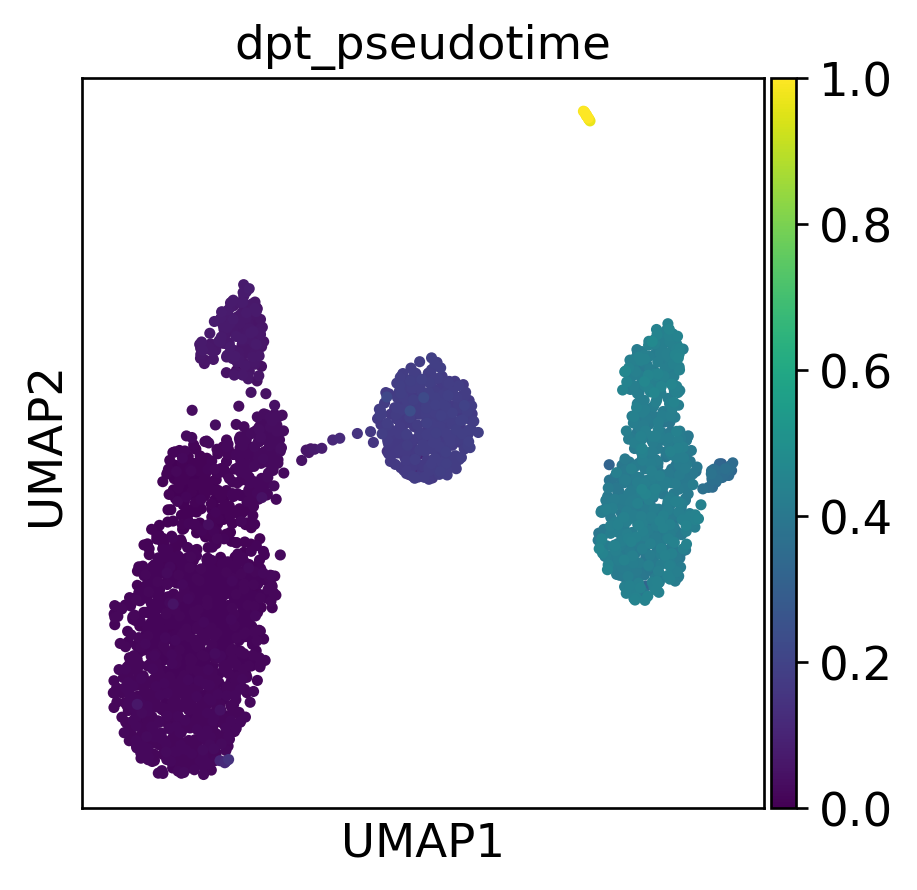

In [20]:
adata_traj = adata.copy()

# use scVI latent we already computed
adata_traj.obsm["X_scVI"] = model.get_latent_representation()

sc.pp.neighbors(adata_traj, use_rep="X_scVI")
sc.tl.umap(adata_traj)

# diffusion pseudotime (DPT)
sc.tl.diffmap(adata_traj)

# choose a root cell (e.g., an arbitrary cell, or based on marker expression)
adata_traj.uns["iroot"] = 0
sc.tl.dpt(adata_traj)

sc.pl.umap(adata_traj, color=["dpt_pseudotime"], color_map="viridis")

These figures illustrate the progression of a single-cell RNA sequencing (scRNA-seq) analysis, specifically focusing on automated cell-type annotation and trajectory inference (pseudotime).